# First Steps

In this tutorial, we'll create our first fully simulated scenario: a server connected to solar power with battery backup.

In [1]:
import vessim as vs

# For plotting results
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Required for running Mosaic in Jupyter notebooks (fixes asyncio event loop conflicts)
import nest_asyncio
nest_asyncio.apply()

We'll create a single microgrid with:

- **A server** that constantly uses 700W
- **A solar power system** that produces up to 5kW (using real weather data provided by [Solcast](https://solcast.com)
- **A battery** that can store up to 1500Wh of energy (starts 80% charged, never goes below 30%)
- **A monitor** that writes all progress to a CSV file

The simulation covers a 24 hour period in Berlin on June, 2022.

In [14]:
# Create the simulation environment
environment = vs.Environment(sim_start="2022-06-09 00:00:00")

# Logs all relevant simulation data to a CSV file
monitor = vs.Monitor(outfile="result.csv")

# Add a single microgrid to the simulation
environment.add_microgrid(
    actors=[
        # Server that consumes 700W constantly
        vs.Actor(
            name="server",
            signal=vs.MockSignal(value=-700),  # negative = consumes power
        ),
        # Solar panel that produces up to 5kW based on the Berlin dataset provided by Solcast
        vs.Actor(
            name="solar_panel",
            signal=vs.HistoricalSignal.load(
                "solcast2022_global", 
                column="Berlin", 
                params={"scale": 5000}  # 5kW maximum
            ),
        ),
    ],
    controllers=[
        monitor
    ],
    storage=vs.SimpleBattery(
        capacity=1500,      # 1500Wh capacity
        initial_soc=0.8,    # Start 80% charged
        min_soc=0.3         # Never go below 30%
    ),
    step_size=300,  # Simulates the microgrid in 5min steps
)

# Run the simulation for 24 hours
environment.run(until=24 * 3600)

2025-06-27 12:03:03.194 | INFO     | mosaik.async_scenario:start:361 - Starting "Actor" as "server" ...
2025-06-27 12:03:03.199 | INFO     | mosaik.async_scenario:start:361 - Starting "Actor" as "solar_panel" ...
2025-06-27 12:03:03.200 | INFO     | mosaik.async_scenario:start:361 - Starting "Grid" as "Grid-0" ...
2025-06-27 12:03:03.202 | INFO     | mosaik.async_scenario:start:361 - Starting "Controller" as "Monitor-3" ...
2025-06-27 12:03:03.203 | INFO     | mosaik.async_scenario:start:361 - Starting "Storage" as "Storage-0" ...
2025-06-27 12:03:03.208 | INFO     | mosaik.async_scenario:run:697 - Starting simulation.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86400/86400 [00:00<00:00, 376095.42steps/s]
2025-06-27 12:03:03.441 | INFO     | mosaik.async_scenario:run:753 - Simulation finished successfully.


## What happened?

We load the results from disc and take a look at the first few rows. Alternatively, you can access the logs in-memory via `monitor.log`.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the simulation results
df = pd.read_csv("result.csv", parse_dates=[0], index_col=0)

# Create the visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Plot solar power and grid power (p_grid is now directly in Watts!)
ax.plot(df.index, df["solar_panel.p"], color="orange", label="Solar Power", linewidth=2)
ax.plot(df.index, df["p_grid"], color="blue", label="Grid Power", linewidth=2)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# Format the chart
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.grid(True, alpha=0.3)
ax.set_xlabel("Time of Day")
ax.set_ylabel("Power (W)")
ax.set_title("Solar vs Grid Power Over 24 Hours")
ax.legend()

plt.tight_layout()
plt.show()

print("Key insights:")
print(f"- Maximum solar power: {df['solar_panel.p'].max():.0f}W")
print(f"- Server power consumption: 700W constant")
print(f"- Hours with excess solar: {len(df[df['solar_panel.p'] > 700])//60:.1f} hours")

The log contains metrics from all consumers, producers, the battery, and the grid.
Let's visualize the results to see the key patterns:

- **At night**: No solar power, so the battery provides power until it's depleted, then power comes from the grid
- **During the day**: Solar panels produce more power than the server needs, so excess energy charges the battery
- **Morning/evening**: Solar power gradually increases/decreases, creating interesting transitions

The chart below shows when power comes from solar (yellow) vs. the grid (blue).

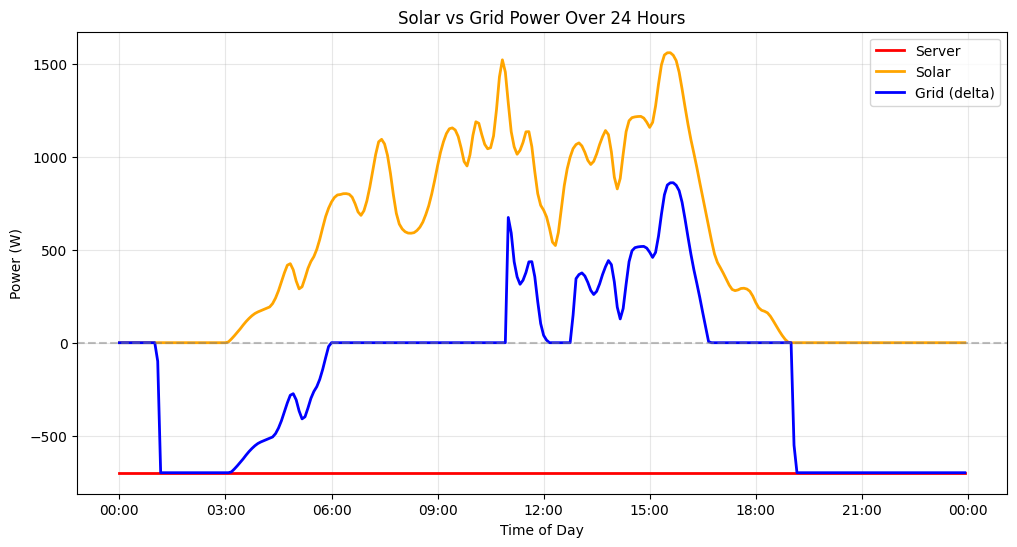

In [19]:
# Load the simulation results
df["grid_power"] = df["e_delta"] / 300  # Convert to power (W)

# Create the visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Plot solar power and grid power
ax.plot(df.index, df["server.p"], color="red", label="Server", linewidth=2)
ax.plot(df.index, df["solar_panel.p"], color="orange", label="Solar", linewidth=2)
ax.plot(df.index, df["grid_power"], color="blue", label="Grid (delta)", linewidth=2)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# Format the chart
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.grid(True, alpha=0.3)
ax.set_xlabel("Time of Day")
ax.set_ylabel("Power (W)")
ax.set_title("Solar vs Grid Power Over 24 Hours")
ax.legend()
plt.show()

In [17]:
df["2022-06-09 11:00:00":"2022-06-09 11:20:00"]

,p_delta,e_delta,server.p,solar_panel.p,policy.mode,policy.charge_power,storage.soc,storage.charge_level,storage.capacity,storage.min_soc,storage.c_rate,grid_power
time,,,,,,,,,,,,
2022-06-09 11:00:00,590.525,202296.0,-700,1290.525,grid-connected,0.0,1.0,1500.0,1500,0.3,NaN,3371.600
2022-06-09 11:05:00,435.825,177157.5,-700,1135.825,grid-connected,0.0,1.0,1500.0,1500,0.3,NaN,2952.625
2022-06-09 11:10:00,354.575,130747.5,-700,1054.575,grid-connected,0.0,1.0,1500.0,1500,0.3,NaN,2179.125
2022-06-09 11:15:00,314.555,106372.5,-700,1014.555,grid-connected,0.0,1.0,1500.0,1500,0.3,NaN,1772.875
2022-06-09 11:20:00,336.190,94366.5,-700,1036.190,grid-connected,0.0,1.0,1500.0,1500,0.3,NaN,1572.775


In [ ]:
print("Key insights:")
print(f"- Maximum solar power: {df['solar_panel.p'].max():.0f}W")
print(f"- Server power consumption: 700W constant")
print(f"- Hours with excess solar: {len(df[df['solar_panel.p'] > 700])//60:.1f} hours")